# Test file

Here we test other approaches which may be promising

In [2]:
import qutip
from functions import *

## Looking for states that work

In [3]:
N_binom = 20
N = N_binom
rho_binom = qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N, 4)).unit())
noisy_rho_binom = create_states(N, [1], rho_binom, 0.1)[0]
vd_rho_binom = (noisy_rho_binom**3/(noisy_rho_binom**3).tr())

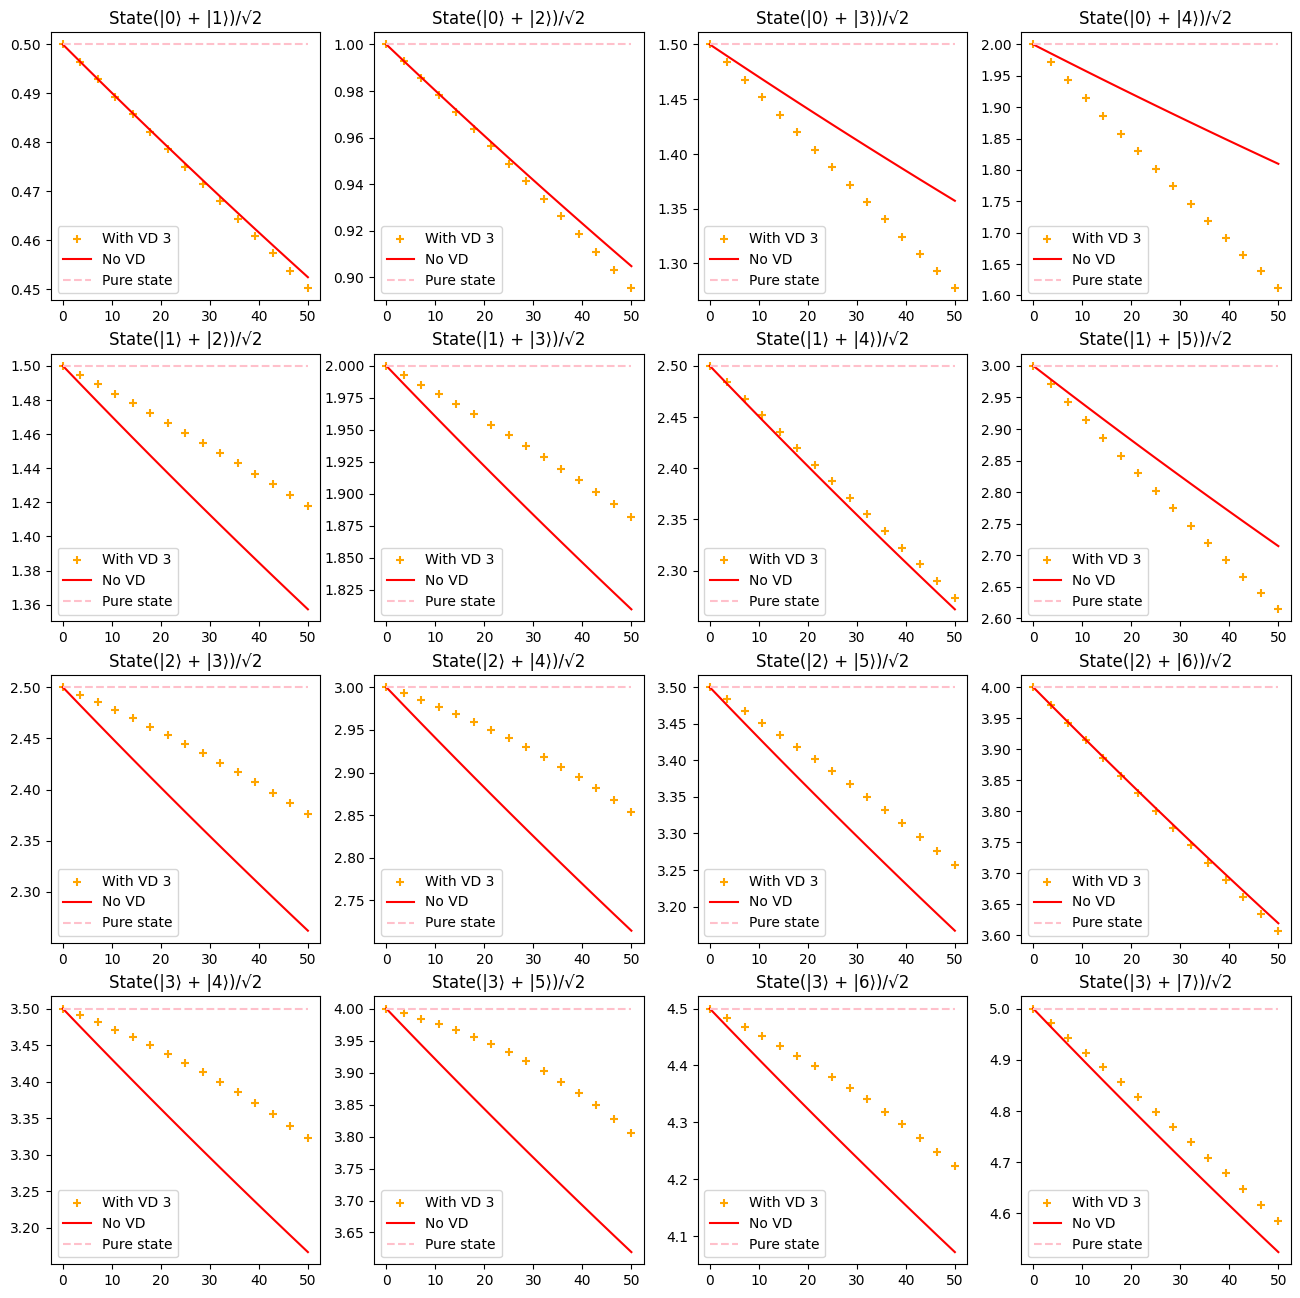

In [4]:
N=N_binom
def plot_th(rho, N, f, ax, title):
    t_list = np.linspace(0, 50, 15)
    kappa = 1/500
    noisy_rho_list = create_states(N, t_list, rho, kappa)
    vd_list = [noisy_rho**3/(noisy_rho**3).tr() for noisy_rho in noisy_rho_list]

    photon_number_no_vd = [qutip.expect(qutip.num(N), noisy_rho) for noisy_rho in noisy_rho_list]
    photon_number_vd = [qutip.expect(qutip.num(N), vd_rho) for vd_rho in vd_list]

    photon_number_vd_inf_th = 2*(2*np.exp(-4*kappa*t_list))/(1+np.exp(-4*kappa*t_list))
    #ax.scatter(t_list, photon_number_no_vd, label="Without VD", c='r', marker='+')
    ax.scatter(t_list, photon_number_vd, label="With VD 3", c='orange', marker='+')
    #plt.plot(t_list, photon_number_vd_inf_th, label="VD inf limit", c='orange')
    init_photon_number = qutip.expect(qutip.num(N), rho)
    ax.plot(t_list, init_photon_number*np.exp(-kappa*t_list), c='r', label='No VD')
    ax.plot(t_list, np.full_like(t_list, init_photon_number), label="Pure state", c='pink', linestyle='dashed')
    ax.legend()
    ax.set_title("State" + title)
    #ax.set_xlabel("Time (μs)")

size=4
fig, ax = plt.subplots(size, size, figsize=(16, 16))
#fig.suptitle("Measuring number operator using Virtual Distillation on noisy generalized binomial states")
for i in range(size):
    for j in range(size):
        rho = qutip.ket2dm((qutip.fock(N, i) + qutip.fock(N, i+j+1)).unit())
        plot_th(rho, N, fig, ax[i][j], f"(|{i}⟩ + |{i+j+1}⟩)/√2")

In most of the cases there is a benefit (yellow points above the red curve) ! The protocol breaks down when the first term is $\ket0$ or when the second term is too far from the first one.

# ----- Theoretical plots -----
Let’s look at some scaling for high Fock states or high number of modes

In [5]:
nb_points = 1000
nb_curves = 9 # modes, starts at 1
nb_n = 50 # Fock state, starts at 1
gamma_list_complete = np.linspace(0,1,nb_points)
theoretical_curves = np.zeros((nb_n, nb_curves, nb_points))
names = [["" for j in range(nb_curves)] for i in range(nb_n)]

for n_ in range(1,nb_n+1):
    theoretical_curves[n_-1][0] = n_ * np.exp(-gamma_list_complete)
    names[n_-1][0] = f"No VD, state |{n_}>"

kappa = 1/500
temporary = (np.exp(kappa * gamma_list_complete)-1)
for n_ in range(1,nb_n+1):
    for M in range(1,nb_curves):
        numerator = np.zeros_like(gamma_list_complete, dtype='O')
        denominator = np.zeros_like(gamma_list_complete, dtype='O')
        for k in range(n_+1):
            coef = (math.comb(n_, k)**M)
            numerator+=(n_-k)*coef *temporary**(M*k)
            denominator+=coef *temporary**(M*k)
        theoretical_curves[n_-1][M] = numerator/denominator
        names[n_-1][M] = f"{M+1}-mode VD, state |{n_}>"

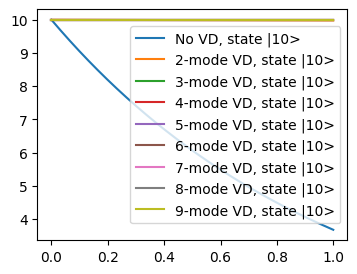

In [6]:
plt.figure(figsize=(4, 3))
for i in range(9,10):
    for j in range(nb_curves):
        plt.plot(gamma_list_complete, theoretical_curves[i][j], label=names[i][j])
plt.legend()

0.10010010010010009


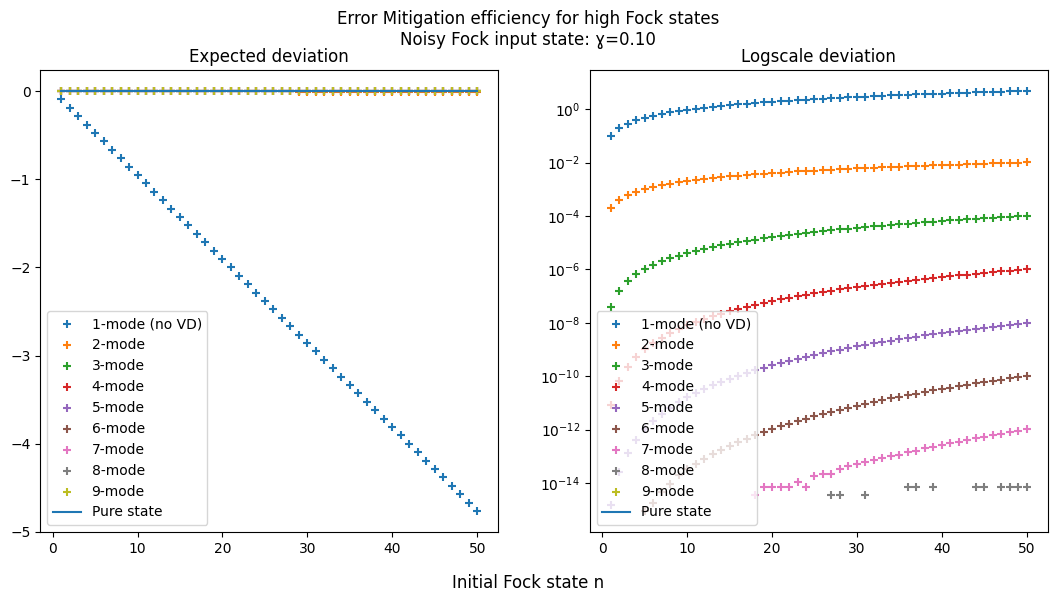

In [7]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for j in range(nb_curves):
    axes[0].scatter(np.arange(1,nb_n+1), theoretical_curves[:,j,fixed_gamma_index] -np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
    axes[1].scatter(np.arange(1,nb_n+1), -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
axes[0].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Initial Fock state n")
f.suptitle(f"Error Mitigation efficiency for high Fock states\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

On the right plot we see pretty clearly the exponential scaling of the correction as the number of modes increases. In fact, the spacing is the same between each curve, because we are looking at $\log(p^M)=M*\log p$ for different values of M.

We also see that the deviation seems to stabilize, but looking at the left plot it rather seems that it grows linearly with $n$.

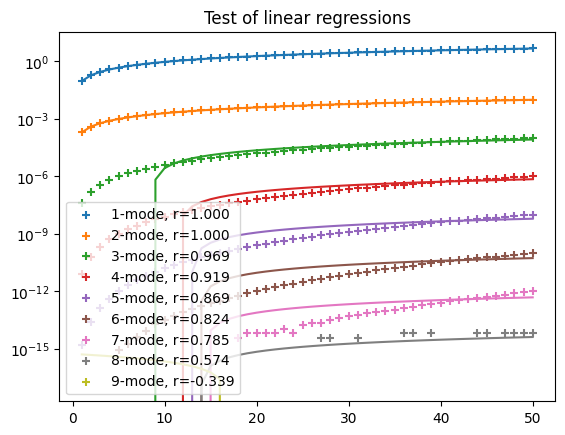

In [8]:
import scipy.stats as sts
x = np.arange(1, nb_n+1)
for j in range(nb_curves):
    a = x-theoretical_curves[:,j,fixed_gamma_index]
    slope, intercept, r, p, se = sts.linregress(x, a)
    plt.scatter(x, a, marker='+', label=f"{j+1}-mode, r={r:.3f}")
    plt.plot(x, slope*x+intercept)
plt.yscale("log")
plt.title("Test of linear regressions")
plt.legend()

Ok for few modes but as soon as we go further it’s not that clear


## Eigenvector analysis

In [9]:
# find eigenvectors of this array
def print_eigen(rho, N, threshold=1e-5):
    ''' Prints eigenvalues and eigenvectors of the density matrix rho, with a threshold for the coefficients
    Returns the dominant eigenvector'''
    eigvals, eigvecs = np.linalg.eig(rho.data.toarray())
    #p = eigvals.argsort(0); inv = np.empty_like(p);   inv[p] = np.arange(p.size)
    #eigvals = eigvals[p[::-1]]
    #eigvecs = eigvecs[p[::-1]]
    #print(eigvals); print(eigvecs)
    for (i, eigval) in enumerate(eigvals):
        if eigval.real<threshold: continue
        s=""
        for j in range(N):
            coef = eigvecs[j][i]
            if abs(coef)>threshold:
                if s!="": s+= " + "
                s += f"{(coef.real if coef.imag<threshold else coef):.3f}|{j}⟩⟨{j}|"
        print(f"Probability {eigval.real:.2f}: {s}")
    return eigvecs[:,np.argmax(eigvals)]
N = N_binom
print_eigen(noisy_rho_binom, N_binom)

Probability 0.84: 0.774|0⟩⟨0| + 0.633|4⟩⟨4|
Probability 0.00: -0.633|0⟩⟨0| + 0.774|4⟩⟨4|
Probability 0.00: 1.000|1⟩⟨1|
Probability 0.02: 1.000|2⟩⟨2|
Probability 0.14: 1.000|3⟩⟨3|


array([ 0.77376434+0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
        0.63347356-0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j,
       -0.        -0.j, -0.        -0.j, -0.        -0.j, -0.        -0.j])

In [10]:
qutip.expect(qutip.num(N), noisy_rho_binom), qutip.expect(qutip.num(N), vd_rho_binom)

(1.809674836071919, 1.6118413779016183)

GKP

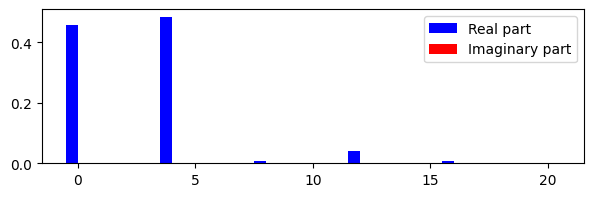

In [11]:
N = 21
psi_gkp = gkp_state(0.4, N)
rho_gkp = qutip.ket2dm(psi_gkp)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N)-0.25, np.real(np.diag(rho_gkp)), width=0.5, color='b', label='Real part')
plt.bar(np.arange(N)+0.25, np.imag(np.diag(rho_gkp)), width=0.5, color='r', label='Imaginary part')
plt.legend()

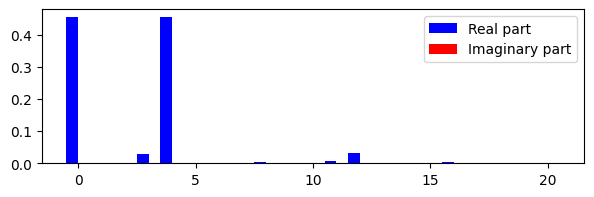

In [12]:
gamma_list = np.linspace(0,0.2,40)
noisy_gkp_list = create_states(N, gamma_list, rho_gkp, 1)

plt.figure(figsize=(7,2))
plt.bar(np.arange(N)-0.25, np.real(np.diag(noisy_gkp_list[3])), width=0.5, color='b', label='Real part')
plt.bar(np.arange(N)+0.25, np.imag(np.diag(noisy_gkp_list[3])), width=0.5, color='r', label='Imaginary part')
plt.legend()

In [13]:
dom_eigen = print_eigen(noisy_gkp_list[-1], N, threshold=1e-3)

Probability 0.68: 0.820|0⟩⟨0| + -0.005|2⟩⟨2| + 0.566|4⟩⟨4| + 0.021|6⟩⟨6| + -0.042|8⟩⟨8| + -0.005|10⟩⟨10| + 0.074|12⟩⟨12| + 0.004|14⟩⟨14| + 0.020|16⟩⟨16| + 0.005|18⟩⟨18| + -0.005|20⟩⟨20|
Probability 0.08: -0.020|0⟩⟨0| + 0.896|2⟩⟨2| + 0.040|4⟩⟨4| + -0.147|6⟩⟨6| + -0.022|8⟩⟨8| + 0.386|10⟩⟨10| + 0.020|12⟩⟨12| + 0.143|14⟩⟨14| + 0.042|16⟩⟨16| + -0.048|18⟩⟨18|
Probability 0.21: -0.005|1⟩⟨1| + 0.967|3⟩⟨3| + 0.043|5⟩⟨5| + -0.105|7⟩⟨7| + -0.013|9⟩⟨9| + 0.217|11⟩⟨11| + 0.011|13⟩⟨13| + 0.070|15⟩⟨15| + 0.019|17⟩⟨17| + -0.020|19⟩⟨19|
Probability 0.01: 0.181|0⟩⟨0| + -0.008|2⟩⟨2| + -0.250|4⟩⟨4| + -0.030|6⟩⟨6| + 0.819|8⟩⟨8| + 0.038|10⟩⟨10| + 0.420|12⟩⟨12| + 0.137|14⟩⟨14| + -0.190|16⟩⟨16| + 0.002|18⟩⟨18|
Probability 0.02: 0.669|1⟩⟨1| + 0.004|3⟩⟨3| + -0.191|5⟩⟨5| + -0.027|7⟩⟨7| + 0.645|9⟩⟨9| + 0.030|11⟩⟨11| + 0.283|13⟩⟨13| + 0.086|15⟩⟨15| + -0.108|17⟩⟨17| + 0.001|19⟩⟨19|
Probability 0.00: -0.037|1⟩⟨1| + -0.019|3⟩⟨3| + -0.011|5⟩⟨5| + 0.786|7⟩⟨7| + 0.006|9⟩⟨9| + 0.536|11⟩⟨11| + 0.167|13⟩⟨13| + -0.255|15⟩⟨1

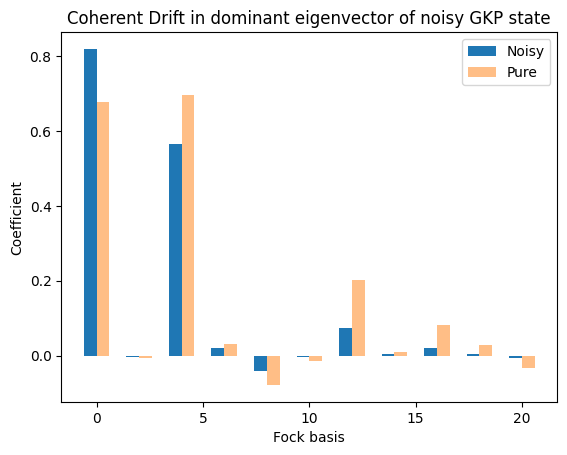

In [14]:
plt.bar(np.arange(N)-0.3, np.real(dom_eigen), width=0.6, label="Noisy")
plt.bar(np.arange(N)+0.3, np.real(psi_gkp.full().flatten()), width=0.6,alpha=0.5, label="Pure")
plt.title("Coherent Drift in dominant eigenvector of noisy GKP state")
plt.xlabel("Fock basis")
plt.ylabel("Coefficient")
plt.legend()

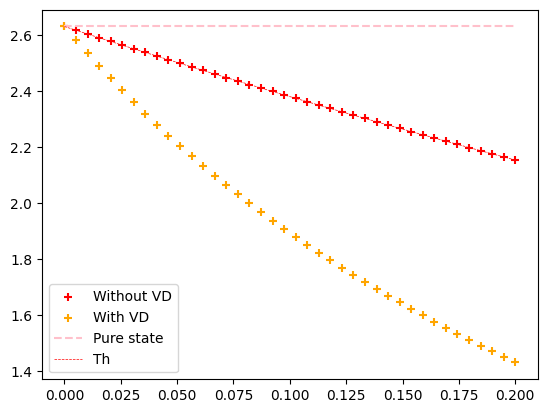

In [15]:
N=21
no_VD_result_list = [qutip.expect(qutip.num(N), rho) for rho in noisy_gkp_list]
VD_result_list = [qutip.expect(qutip.num(N), rho**3/(rho**3).tr()) for rho in noisy_gkp_list]
# plot a scatter with the results
plt.scatter(gamma_list, no_VD_result_list, label="Without VD", c='r', marker='+')
plt.scatter(gamma_list, VD_result_list, label="With VD", c='orange', marker='+')
init_photon_number = qutip.expect(qutip.num(N), psi_gkp)
plt.plot(gamma_list, np.full_like(gamma_list, init_photon_number), label="Pure state", c='pink', linestyle='dashed')
plt.plot(gamma_list, np.exp(-gamma_list)*init_photon_number, label="Th",linewidth=0.5, c='r', linestyle='dashed')
plt.legend()

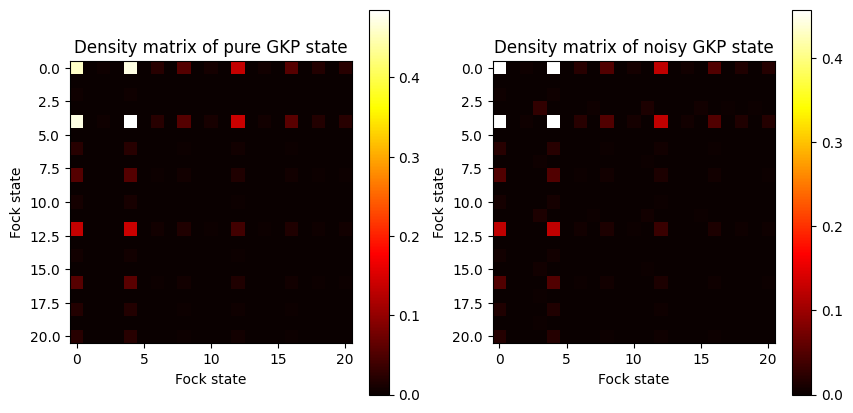

In [16]:
def density_matrix_color_map(rho, title, fig, ax):
    ''' Plots the density matrix rho in a color map'''
    p = ax.imshow(np.abs(rho.full()), cmap='hot', interpolation='nearest')
    fig.colorbar(p)
    ax.set_title("Density matrix of " + title)
    ax.set_xlabel("Fock state")
    ax.set_ylabel("Fock state")

fig, ax = plt.subplots(1,2, figsize=(10,5))
density_matrix_color_map(rho_gkp, "pure GKP state", fig, ax[0])
density_matrix_color_map(noisy_gkp_list[3], "noisy GKP state", fig, ax[1])

## ----- Plots for report and tests ------

Text(0, 0.5, 'Coefficient')

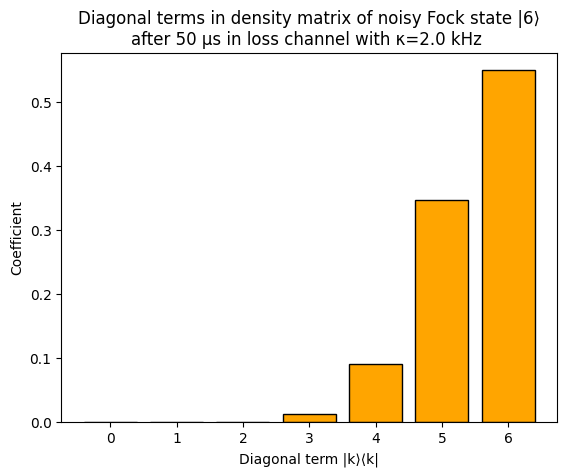

In [17]:
N=10
n=6
t=50
rho = create_states(N, [t], qutip.fock_dm(N,n), kappa, 1)[0]
plt.bar(np.arange(n+1),np.abs(np.diag(rho))[:n+1], color='orange', linestyle='-', edgecolor='black')
plt.title(f"Diagonal terms in density matrix of noisy Fock state |{n}⟩\nafter {t} μs in loss channel with κ={1000*kappa} kHz ")
plt.xlabel("Diagonal term |k⟩⟨k|")
plt.ylabel("Coefficient")

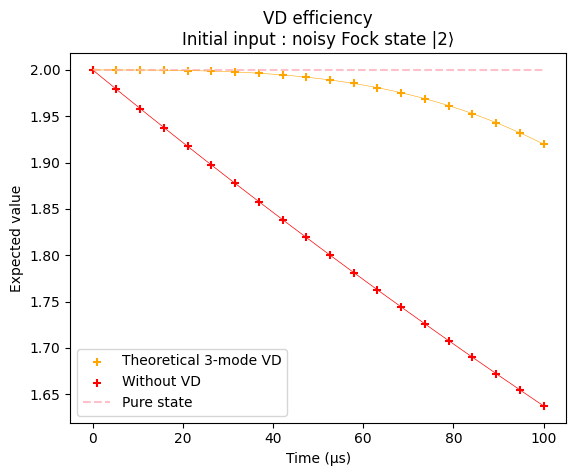

In [18]:
# same t_list as the beginning
import qutip
from functions import *
t_max = 100
N=5
n=2
nb_samples = 20
T_1=500 # μs
kappa = 1/T_1
t_list = np.linspace(0,t_max,nb_samples)
rho_list = create_states(N, t_list, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

r, r_loss, r_th = perform_protocol(N, rho_list, [], [1,3], False, None)
r_th_1, r_th_3 = r_th
plot_all(t_list, r, r_loss, [(r_th_3, "Theoretical 3-mode VD"), (r_th_1, "Without VD"),],
         title="Fock state |2⟩", kappa=kappa, gamma_loss=None, show_only_th=True, show_curves=n)

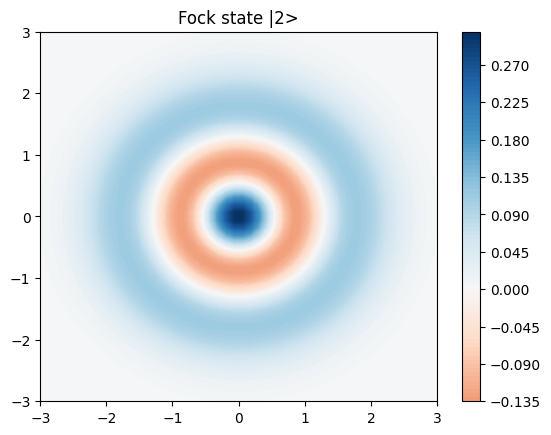

In [19]:
bound = 3
xvec, yvec = np.linspace(-bound,bound,50), np.linspace(-bound,bound,50)
plot_wigner(qutip.fock_dm(N,2), xvec, yvec, plt.figure(), plt.gca(), 'RdBu', "Fock state |2>", density=True)

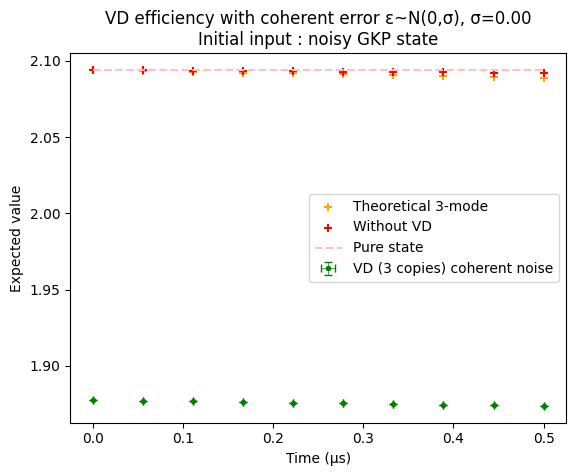

In [20]:
N_ = 10
t_list_gkp = np.linspace(0, 0.5, 10)
delta = 0.4
psi_gkp = gkp_state(delta, N_)
rho_gkp = qutip.ket2dm(psi_gkp)
noisy_gkp_list = create_states(N_, t_list_gkp, rho_gkp, kappa)

F_list = [create_F3(N_, np.sqrt((1/2,1/3,1/2)), np.zeros(3))]

result_gkp, result_gkp_loss, result_gkp_th = perform_protocol(N_,noisy_gkp_list, F_list,
                                                                  [1,3], losses=False)
plot_all(t_list_gkp, result_gkp, result_gkp_loss, [(result_gkp_th[1], "Theoretical 3-mode"),
                        (result_gkp_th[0], "Without VD")], None, "GKP state", 
                        eps_std=0,gamma_loss=None, show_only_th=False)

In [28]:
N_ = 50
rho_gkp = qutip.ket2dm(gkp_state(delta, N_))
print(qutip.expect(qutip.num(N_), rho_gkp))

2.6426925175432276


In [29]:
N_ = 14
rho_gkp = qutip.ket2dm(gkp_state(delta, N_))
rho_full=qutip.tensor([rho_gkp]*3)
bs1, bs2, bs3 = create_F3(N_, np.sqrt((1/2,1/3,1/2)), np.zeros(3))
rho_tilde = bs1*bs2*bs3*rho_full*bs3.dag()*bs2.dag()*bs1.dag()

n1 = qutip.tensor(qutip.num(N_),  qutip.identity(N_), qutip.identity(N_))
n2 = qutip.tensor(qutip.identity(N_), qutip.num(N_),  qutip.identity(N_))
n3 = qutip.tensor(qutip.identity(N_), qutip.identity(N_), qutip.num(N_))
denominator_op = (2j*np.pi/3*(n1+2*n2)).expm()
numerator_op = (n1+n2+n3)/3 * denominator_op

print(qutip.expect(qutip.num(N_), rho_gkp))

print(qutip.expect(numerator_op, rho_tilde)/qutip.expect(denominator_op, rho_tilde))

2.3104925481319896
(2.192193566849682-0.0014286313055611663j)


## Tests for quadrature measurement

In [22]:
from qutip.measurement import measure
N=50
q_quad_observable = (qutip.destroy(N) + qutip.create(N))/np.sqrt(2)
p_quad_observable = -1j*(qutip.destroy(N) - qutip.create(N))/np.sqrt(2)

psi_fock = qutip.fock(N, 2)
for i in range(10):
    res, _ = measure(psi_fock, (q_quad_observable**2+p_quad_observable**2-1)/2)
    th_res, _ = measure(psi_fock, qutip.num(N))
    print(f"(q^2+p^2-1)/2: {res:.3f},  n: {th_res:.3f}")

(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000
(q^2+p^2-1)/2: 2.000,  n: 2.000


0.15630254688947254

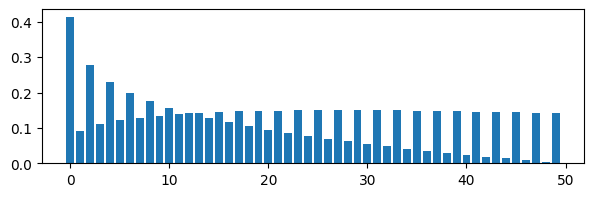

In [23]:
psi_init = qutip.fock(N, 2)
val, psi_proj = measure(psi_init, q_quad_observable)
plt.figure(figsize=(7,2))
plt.bar(np.arange(N), np.abs(psi_proj.full().flatten()))
val

In [24]:
for i in range(5): print(measure(psi_proj, q_quad_observable)[0])

0.15630254688947254
0.15630254688947254
0.15630254688947254
0.15630254688947254
0.15630254688947254
